In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from collections import OrderedDict

In [2]:
class BinarizeLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return torch.sign(input)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input.ge(1)] = 0
        grad_input[input.le(-1)] = 0
        return grad_input

In [3]:
class BinarizedNN(nn.Module):
    def __init__(self):
        super(BinarizedNN, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = BinarizeLayer.apply(self.fc1(x))
        x = BinarizeLayer.apply(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
batch_size = 64
learning_rate = 0.01
num_epochs = 10

# Data loading and preprocessing
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|█████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 115467879.91it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 28903768.51it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 82432136.60it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4513273.81it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [20]:
# Initialize the BNN model and optimizer
model = BinarizedNN()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [21]:
for epoch in range(num_epochs):
    total_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}')


Epoch 1, Loss: 0.6633775181639423
Epoch 2, Loss: 0.35575889029514307
Epoch 3, Loss: 0.3080278907948211
Epoch 4, Loss: 0.2790021988025098
Epoch 5, Loss: 0.2534144875813903
Epoch 6, Loss: 0.23483009349658038
Epoch 7, Loss: 0.21899899395146985
Epoch 8, Loss: 0.206202835765983
Epoch 9, Loss: 0.19348944301035867
Epoch 10, Loss: 0.18290339778465375


In [17]:
# print(train_dataset[-1])
image, label = train_dataset[-1]
print(image.size())
print(image)

torch.Size([1, 28, 28])
tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.00

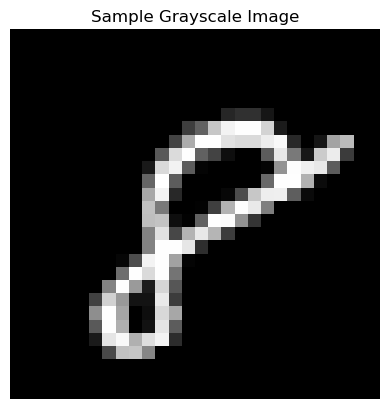

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Create a sample grayscale image (replace with your own image data)
image_array = np.random.randint(0, 256, (100, 100), dtype=np.uint8)

# Display the image
plt.imshow(image[0], cmap='gray')
plt.title('Sample Grayscale Image')
plt.axis('off')
plt.show()

In [19]:
print(model(image))

tensor([[-0.1176,  0.2069, -0.8835, -0.9614, -0.7550, -1.3139, -0.4098, -0.1503,
         -0.2160, -0.9375]], grad_fn=<AddmmBackward0>)


In [29]:
print(model(image))
print(criterion(model(image), torch.tensor([8])))

tensor([[ 2.0402, -2.7933,  0.2155, -1.4287, -2.4812, -0.1660, -2.4578, -0.4502,
          7.5143,  2.6129]], grad_fn=<AddmmBackward0>)
tensor(0.0133, grad_fn=<NllLossBackward0>)


In [32]:
weight_dict = OrderedDict(model.named_parameters())
# weightFunction = weight_dict['fc1.weight'].T
# print("Final weight function: \n", weightFunction)
print(weight_dict)

OrderedDict([('fc1.weight', Parameter containing:
tensor([[ 0.0273,  0.0325,  0.0284,  ..., -0.0088,  0.0063, -0.0199],
        [ 0.0342,  0.0311, -0.0322,  ...,  0.0343,  0.0289,  0.0321],
        [ 0.0215, -0.0061, -0.0183,  ..., -0.0007, -0.0043, -0.0038],
        ...,
        [-0.0168, -0.0274,  0.0098,  ...,  0.0253, -0.0228, -0.0180],
        [ 0.0132,  0.0141, -0.0024,  ...,  0.0012, -0.0105, -0.0242],
        [-0.0362, -0.0324,  0.0033,  ..., -0.0140,  0.0177, -0.0208]],
       requires_grad=True)), ('fc1.bias', Parameter containing:
tensor([-1.7924e-02,  9.6788e-03,  1.4722e-02,  9.2687e-03,  2.9269e-02,
        -1.4365e-02, -1.5164e-02,  7.5562e-04,  1.6438e-02, -3.3028e-02,
         5.3357e-03, -2.5103e-02, -2.7300e-02,  1.4746e-02, -1.7760e-02,
         2.9725e-02, -2.0102e-02, -2.4248e-02,  2.3908e-02, -2.9340e-02,
        -2.8256e-02, -1.3958e-02, -3.1016e-02, -1.5227e-02, -2.9286e-02,
        -8.6596e-03, -2.4534e-02,  9.8886e-03,  2.8703e-02,  3.4174e-02,
         2.190